# Starter Notebook: AIMS Data Science Hackathon by Microsoft

Welcome! This starter notebook is designed to get you started on the AIMS Data Science Hackathon, where you will be attempting to predict a measure of wealth for different locations across Africa. We will take a look at the data, create a model and then use that to make our first submission. After that we will briefly look at some ways to improve. Let's get started.

In [144]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sn

from sklearn.ensemble import RandomForestRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA

#import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error


#SPILITING  DATASET
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler

#Recursive Feature Selection
from sklearn.feature_selection import RFE

# Loading the Data

We're using the pandas library to load the data into dataframes - a tabular data structure that is perfect for this kind of work. Each of the three CSV files from Zindi is loaded into a dataframe and we take a look at the shape of the data (number of rows and columns) as well as a preview of the first 5 rows to get a feel for what we're working with.

In [48]:
#from fastai.tabular.data import *
import warnings
warnings.filterwarnings("ignore")

In [60]:
train = pd.read_csv('Train_Cleaned.csv')
print(train.shape)
train.head()
train.drop("Unnamed: 0",axis=1,inplace=True)

(2977, 315)


In [61]:
train.drop("Field_ID",axis=1,inplace=True)

In [62]:
train.shape

(2977, 313)

In train, we have a set of inputs (like 'urban_or_rural' or 'ghsl_water_surface') and our desired output variable, 'Target'. There are 21454 rows - lots of juicy data!

In [63]:
test = pd.read_csv('Test_Cleaned.csv')
print(test.shape)

(1055, 313)


In [64]:
test.drop("Unnamed: 0",axis=1,inplace=True)
test.head()

,0_CLIM_vs,0_CLIM_vpd,0_CLIM_vap,0_CLIM_tmmx,0_CLIM_tmmn,0_CLIM_swe,0_CLIM_srad,0_CLIM_soil,0_CLIM_ro,0_CLIM_pr,...,11_S2_B12,11_2_B11,11_S2_B10,11_S2_B9,11_S2_B8,11_2_B7,11_S2_B1,11_S2_B6,11_S2_B5,11_S2_B4
0,1133,920,987,781,1252,2551,2926,769,13,1237,...,157,8,618,1990,0,147,296,1811,111,270
1,1140,899,928,696,1129,2604,2951,716,12,1048,...,157,8,618,1990,0,147,296,1811,111,270
2,1117,966,1019,960,1299,2152,2351,688,12,1372,...,153,8,583,2002,0,150,297,1829,112,270
3,1147,923,1032,672,1191,2609,3450,762,12,972,...,153,8,583,2002,0,150,297,1829,112,270
4,1141,987,1047,1343,1441,2055,2097,718,13,1796,...,153,8,583,2002,0,150,297,1829,112,270


In [65]:
train.head().T

,0,1,2,3,4
0_CLIM_vs,1024.000,1023.000,1095.000,976.000,1300.000
0_CLIM_vpd,934.000,880.000,1016.000,777.000,1081.000
0_CLIM_vap,932.000,821.000,1070.000,784.000,1122.000
0_CLIM_tmmx,1173.000,924.000,1357.000,639.000,1162.000
0_CLIM_tmmn,1392.000,1116.000,1632.000,1064.000,1487.000
...,...,...,...,...,...
11_S2_B1,267.000,273.000,274.000,263.000,291.000
11_S2_B6,1680.000,1682.000,1690.000,1688.000,1972.000
11_S2_B5,69.000,75.000,76.000,64.000,87.000
11_S2_B4,210.000,190.000,200.000,210.000,270.000


Test looks just like train but without the 'Target' column and with fewer rows.

In [66]:
ss = pd.read_csv('SampleSubmission.csv')
print(ss.shape)
ss.head()

(1055, 2)


,Field_ID,Yield
0,E9UZCEA,0
1,1WGGS1Q,0
2,EG2KXE2,0
3,HC3GQXF,0
4,7AK6GFK,0


The sample submission is just the ID column from test with a 'Target' column where we will put out predictions.

Now that we have the data loaded, we can start exploring.

# EDA

We will explore some trends in the data and look for any anomalies such as missing data. A few examples are done here but you can explore much further yourself and get to know the data better.

First up: let's see how an input like 'nighttime lights' relates to the target column:

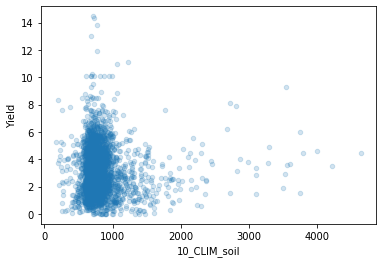

In [67]:
# Plotting the relationship between an input column and the target
train.plot(x='10_CLIM_soil', y='Yield', kind='scatter', alpha=0.2)

See what other trends you can uncover - we have only scratched the surface here. 

# Modelling

We've had a look at our data and it looks good! Let's see if we can create a model to predict the Target given some of our inputs. To start with we will use only the numeric columns, so that we can fit a model right away. 

To evaluate our model, we need to keep some data separate. We will split out data into X (inputs) and y (output) and then further split into train and test sets with the following code:

In [68]:
train.shape

(2977, 313)

In [69]:
from sklearn.model_selection import train_test_split
X,y = train.iloc[:,0:312], train['Yield']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32) # Random state keeps the split consistent
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)
print(X_train.shape, X_test.shape)

(2381, 312) (596, 312)


We now have a nice test set of ~4200 rows. We will train our model and then use this test set to calculate our score.

In [112]:
model = RandomForestRegressor(n_estimators = 200,random_state = 68) # Create the model
model.fit(X_train, y_train) # Train it (this syntax looks the same for all sklearn models)
model.score(X_test, y_test) # Show a score



Multi_lr  = LinearRegression()
Multi_lr.fit(X_train, y_train)

DTR   = DecisionTreeRegressor(random_state=0)
DTR.fit(X_train, y_train)

SVR_lr = SVR(C=1.0,epsilon=0.2,gamma='scale',kernel = 'rbf')
SVR_lr.fit(X_train, y_train)



RaFR  = RandomForestRegressor(n_estimators=100,max_depth=4,random_state=0)
RaFR.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [110]:
MRLPR = MLPRegressor(hidden_layer_sizes=(64,64,64),activation="relu",random_state=1, max_iter=2000).fit(X_train, y_train)

In [ ]:
#Estimator can be ML Model

selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X_train, y_train)
selector.support_
selector.ranking_

In [105]:
def argmax(history):
    maxRMSE = max(history, key=lambda x:x['rmse'])
    minRMSE = min(history, key=lambda x:x['rmse'])
    return(maxRMSE,minRMSE)

In [106]:
n_es = list(range(1,100))
m_depth = list(range(1,10))
history = []
record = {}
for i in m_depth:
    for j in n_es:
        RaFR  = RandomForestRegressor(n_estimators=j,max_depth=i,random_state=0)
        RaFR.fit(X_train, y_train)
        #print(f"RaFR {mean_squared_error(y_test, RaFR.predict(X_test), squared=False)} max_depth = {i} n_estimators={j}")
        record["n_estimators"] = j
        record["max_depth"] = i
        record["rmse"] = mean_squared_error(y_test, RaFR.predict(X_test), squared=False)
        history.append(record)
argmax(history)

KeyboardInterrupt: 

In [107]:
argmax(history)

({'n_estimators': 34, 'max_depth': 4, 'rmse': 1.4971148576156899},
 {'n_estimators': 34, 'max_depth': 4, 'rmse': 1.4971148576156899})

In [113]:
# The `squared=False` bit tells this function to return the ROOT mean squared error
print(f"RFR {mean_squared_error(y_test, model.predict(X_test), squared=False)}")
print(f"Multi_lr {mean_squared_error(y_test, Multi_lr.predict(X_test), squared=False)}")
print(f"DTR {mean_squared_error(y_test, DTR.predict(X_test), squared=False)}")
print(f"SVR_lr {mean_squared_error(y_test, SVR_lr.predict(X_test), squared=False)}")

print(f"RaFR {mean_squared_error(y_test, RaFR.predict(X_test), squared=False)}")

print(f"MRLPR {mean_squared_error(y_test, MRLPR.predict(X_test), squared=False)}")

RFR 1.526045433697511
Multi_lr 1.7358240790385955
DTR 2.70004486705956
SVR_lr 1.472154356052173
RaFR 1.5042589375448991
MRLPR 2.0026414494697335


In [72]:
#from sklearn import metrics
#print("Accuracy=",metrics.accuracy_score(y_test,prediction_test))
max(model.predict(X_test))


6.724618750000007

What is the score above? The default for regression models is the R^2 score, a measure of how well the mode does at predicting the target. 0.69 is pretty good - let's plot the predictions vs the actual values and see how close it looks to a straight line:

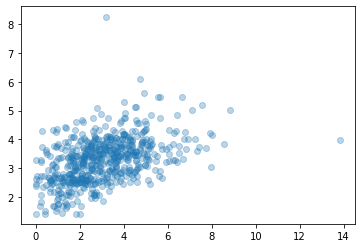

In [77]:
from matplotlib import pyplot as plt
plt.scatter(y_test, RaFR.predict(X_test), alpha=0.3)

This looks great - most predictions are nice and close to the true value! But we still don't have a way to link this to the leaderboard score on Zindi. Let's remedy that by calculating the Root Mean Squared Error, the same metric Zindi uses. 

Great stuff. Let's make a submission and then move on to looking for ways to improve.

In [45]:
test.head()

,0_CLIM_vs,0_CLIM_vpd,0_CLIM_vap,0_CLIM_tmmx,0_CLIM_tmmn,0_CLIM_swe,0_CLIM_srad,0_CLIM_soil,0_CLIM_ro,0_CLIM_pr,...,11_S2_B12,11_2_B11,11_S2_B10,11_S2_B9,11_s2_B8A,11_S2_B8,11_2_B7,11_S2_B1,11_S2_B6,11_S2_B5
0,1133,920,987,781,1252,2551,2926,769,13,1237,...,157,8,618,1990,0,147,296,1811,111,270
1,1140,899,928,696,1129,2604,2951,716,12,1048,...,157,8,618,1990,0,147,296,1811,111,270
2,1117,966,1019,960,1299,2152,2351,688,12,1372,...,153,8,583,2002,0,150,297,1829,112,270
3,1147,923,1032,672,1191,2609,3450,762,12,972,...,153,8,583,2002,0,150,297,1829,112,270
4,1141,987,1047,1343,1441,2055,2097,718,13,1796,...,153,8,583,2002,0,150,297,1829,112,270


In [114]:
# Load the sample submission file
ss = pd.read_csv('SampleSubmission.csv')

# Prep the data, using the same method we did for train
#test_sampled = pd.DataFrame([process_im(fid, folder='image_arrays_test') for fid in ss['Field_ID'].values])

test = StandardScaler().fit_transform(test)

# Get model predictions
preds = RaFR.predict(test)

# Store them in the submission dataframe and save
ss['Yield'] = preds
ss.to_csv('Sub.csv', index=False)
ss.head()

,Field_ID,Yield
0,E9UZCEA,3.667228
1,1WGGS1Q,3.497422
2,EG2KXE2,3.762183
3,HC3GQXF,3.546619
4,7AK6GFK,3.726104


We now have our predictions in the right format to submit. The following line saves this to a file that you can then upload to get a score:

# Getting Better

You might have noticed that your score on Zindi wasn't as good as the one you got above. This is because the test set comes from different countries to the train set. When we did a random split, we ended up with our local train and test both coming from the same countries - and it's easier for a model to extrapolate within countries than it is for it to make predictions for a new location. 

So our first step might be to make a scoring function that splits the data according to country, and measures the model performance on unseen countries. Try it and share your testing methods in the discussions. And look at the following questions:
- Does your score drop when you score your model on countries it wasn't trained with?
- Does the new score more accurately match the leaderboard score?
- Are any countries particularly 'hard' to make predictions in?

In [116]:
# You code for a new model evaluation method here
# create our instances

import xgboost as xgb
#from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 

In [117]:


xgbr = xgb.XGBRegressor(n_estimators = 300,learning_rate = 1,early_stopping_rounds = 15,verbosity=0)
print(xgbr)

xgbr.fit(X_train, y_train)
 
score = xgbr.score(X_train, y_train)   
print("Training score: ", score) 



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=15,
             gamma=0, importance_type='gain', learning_rate=1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)
Training score:  0.9843407525418766


Mean cross-validation score: -0.38
K-fold CV average score: -0.39
MSE: 4.35
RMSE: 2.09


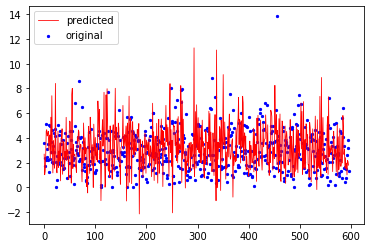

In [119]:
# - cross validataion 
scores = cross_val_score(xgbr, X_train, y_train, cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

kfold = KFold(n_splits=3, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
 
ypred = xgbr.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()


In [123]:
# Load the sample submission file
ss = pd.read_csv('SampleSubmission.csv')

# Prep the data, using the same method we did for train
#test_sampled = pd.DataFrame([process_im(fid, folder='image_arrays_test') for fid in ss['Field_ID'].values])

test = StandardScaler().fit_transform(test)

# Get model predictions
preds = xgbr.predict(test)

# Store them in the submission dataframe and save
ss['Yield'] = preds

ss.head(10)

,Field_ID,Yield
0,E9UZCEA,5.714817
1,1WGGS1Q,7.106826
2,EG2KXE2,-0.185730
3,HC3GQXF,6.455561
4,7AK6GFK,2.285595
5,QBM8DGN,4.240309
6,1H0WQXK,6.284381
7,CWDN5MZ,6.868127
8,PTAP92J,5.773428
9,NTTFH97,6.479784


In [124]:
ss.to_csv('Sub.csv', index=False)

Knowing how well our model is doing is useful, but however you measure that we also need ways to improve this performance! There are a few ways to do this:

- Feed the model better data. How? Feature engineering! If we can add meaningful features the model will have more data to work with.
- Tune your models. We used the default parameters - perhaps we can tweak some hyperparameters to make our models better
- Try fancier models. Perhaps XGBoost or a neural network is better than Random Forest at this task

Let's do a little of each. First up, let's create a numeric feature that encodes the 'urban_or_rural' column as something the model can use:

Did your score improve?

Next, let's tune our model by adjusting the maximum depth. This is one of many hyperparameters that can be tweaked on a Random Forest model. Here I just try a few randomly chosen values, but you could also use a grid search to try values more methodically.

In [127]:
for max_depth in [3, 5, 8, 10, 14, 18]:
    for n_estimators in [100,150,200,250,300]:
        model = RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth,random_state=0)
        # Again, you van use a better method to evaluate the model here...
        model.fit(X_train, y_train)
        print(f"max_depth = {max_depth} n_estimators = {n_estimators} rmse = { mean_squared_error(y_test, model.predict(X_test), squared=False)}") 

max_depth = 3 n_estimators = 100 rmse = 1.4870390563831715
max_depth = 3 n_estimators = 150 rmse = 1.4878553408004884
max_depth = 3 n_estimators = 200 rmse = 1.4865621622784349
max_depth = 3 n_estimators = 250 rmse = 1.4862368307654985
max_depth = 3 n_estimators = 300 rmse = 1.4896095212575113
max_depth = 5 n_estimators = 100 rmse = 1.5220449424426117
max_depth = 5 n_estimators = 150 rmse = 1.5271571278838203
max_depth = 5 n_estimators = 200 rmse = 1.5225463438268183
max_depth = 5 n_estimators = 250 rmse = 1.5186752836085766
max_depth = 5 n_estimators = 300 rmse = 1.5188325713348825
max_depth = 8 n_estimators = 100 rmse = 1.5234645648629845
max_depth = 8 n_estimators = 150 rmse = 1.5401988935122202
max_depth = 8 n_estimators = 200 rmse = 1.5337532655148183
max_depth = 8 n_estimators = 250 rmse = 1.5296931465144161
max_depth = 8 n_estimators = 300 rmse = 1.5301375124530012
max_depth = 10 n_estimators = 100 rmse = 1.532466741624681
max_depth = 10 n_estimators = 150 rmse = 1.5444610545886

In this case, it looks like we can improve our performance by specifying a max_depth to limit model complexity.

Finally, let's try a different model out of curiosity:

In [141]:
from catboost import CatBoostRegressor
# Exercise: fit and score the model. Does it beat your other scores? Can you use it to make a submission?
model = CatBoostRegressor(iterations=10,learning_rate=1,depth=16)
# Fit model
model.fit(X_train, y_train)
# Get predictions
print(mean_squared_error(y_test, model.predict(X_test), squared=False))

0:	learn: 1.3717049	total: 36s	remaining: 5m 24s
1:	learn: 1.1622052	total: 1m 31s	remaining: 6m 4s
2:	learn: 0.9339634	total: 2m 16s	remaining: 5m 17s
3:	learn: 0.7903798	total: 2m 57s	remaining: 4m 26s
4:	learn: 0.6732660	total: 3m 39s	remaining: 3m 39s
5:	learn: 0.5703193	total: 4m 21s	remaining: 2m 54s
6:	learn: 0.4758728	total: 5m 1s	remaining: 2m 9s
7:	learn: 0.4117455	total: 5m 44s	remaining: 1m 26s
8:	learn: 0.3689931	total: 6m 28s	remaining: 43.1s
9:	learn: 0.3241637	total: 7m 7s	remaining: 0us
1.6118150786812022


In [146]:
XX = StandardScaler().fit_transform(X)
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(XX)


In [147]:
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3',\
                                                                  'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])

In [148]:
principalDf.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,9.880240,-4.661956,9.222531,-0.608610,-6.021890,3.735541,1.167637,-3.944419,16.754877,-6.395049
1,7.916839,-4.138729,6.492092,-3.164512,-4.414941,-0.929412,-0.493082,-4.493983,-0.694407,4.308019
2,10.449703,-3.325766,12.818180,1.862554,-8.861755,7.886094,6.385353,-1.616659,19.151537,-9.402268
3,10.821314,-2.975712,14.755181,2.321320,-2.236298,9.404378,2.579940,1.133918,-6.756436,-3.068698
4,-3.572563,0.144873,3.393827,7.726701,-4.846198,0.153034,0.654158,-0.235890,-0.602683,2.403832


In [150]:
pca.explained_variance_ratio_

array([0.16657315, 0.12655973, 0.08862694, 0.08151486, 0.0496035 ,
       0.03650247, 0.03367869, 0.03174189, 0.0297556 , 0.02875222])

In [152]:
pca = PCA(.95)
pca.fit(X_train)
train_img = pca.transform(X_train)
test_img = pca.transform(X_test)

In [155]:
model = RandomForestRegressor(n_estimators=100,max_depth=3,random_state=0)
        # Again, you van use a better method to evaluate the model here...
model.fit(train_img, y_train)
print(mean_squared_error(y_test, model.predict(test_img), squared=False))

1.5012701530306802


Remember, you can ask questions and share ideas in the discussions. 

### GOOD LUCK!